
# **Preparing the dataset**

Prepare the dataset using Labelme annotation tool (for Instance segmentation) and LabelImg for object detection.


In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Installing Detectron2 on Colab**

In [2]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 35.8 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp38-cp38-linux_x86_64.whl size=44089 sha256=b63a4ca948d5fcf929fe52de23420e50257b2cb28e1deb92b8b116b1905b483a
  Stored in directory: /root/.cache/pip/wheels/52/dd/2b/10ff8b0ac81b93946bb5fb9e6749bae2dac246506c8774e6cf
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.2.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/

In [3]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.3 MB 524 kB/s 
     |████████████████████████████████| 79 kB 9.4 MB/s 
     |████████████████████████████████| 154 kB 77.7 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
     |████████████████████████████████| 130 kB 73.4 MB/s 
     |████████████████████████████████| 117 kB 54.6 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61431 sha256=6e50d1cd628c4a299d54cfa0fc75aaac70b8b2d2f45426668e327c4bca438ba9
  Stored in directory: /root/.cache/pip/wheels/b8/79/07/c0e9367f5b5ea325e246bd73651e8af175fabbef943043b1cc
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=a2c8b28d0f94ee2ebb345d57d4b40d1176153fc11aaab1f83074599c12f58d64
  Stored in 

In [3]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2
     

# **Register the data to Detectron2 config**

In [4]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

In [5]:
def get_data_dicts(directory, classes):
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = 3840
        record["width"] = 5760
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']] # x coord
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts
     

In [12]:
classes = ['adlabel', 'streetsign']

data_path = '/content/drive/MyDrive/datasetz/'

for d in ["train", "test"]:
    DatasetCatalog.register(
        "category_" + d, 
        lambda d=d: get_data_dicts(data_path+d, classes)
    )
    MetadataCatalog.get("category_" + d).set(thing_classes=classes)

microcontroller_metadata = MetadataCatalog.get("category_train")
     

# **Training the Detectron2 Instance Segmentation Model**

In [6]:

from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode, Visualizer

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("category_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [13]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[12/30 18:07:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [12]:
trainer.train()

[12/30 16:57:02 d2.engine.train_loop]: Starting training from iteration 0
[12/30 16:57:39 d2.utils.events]:  eta: 0:29:36  iter: 19  total_loss: 1.982  loss_cls: 1.064  loss_box_reg: 0.09161  loss_mask: 0.6955  loss_rpn_cls: 0.09481  loss_rpn_loc: 0.02245  time: 1.8023  data_time: 1.3659  lr: 4.9953e-06  max_mem: 2548M
[12/30 16:58:13 d2.utils.events]:  eta: 0:27:40  iter: 39  total_loss: 1.834  loss_cls: 0.9473  loss_box_reg: 0.09823  loss_mask: 0.6842  loss_rpn_cls: 0.05958  loss_rpn_loc: 0.01748  time: 1.7411  data_time: 1.1420  lr: 9.9902e-06  max_mem: 2548M
[12/30 16:58:46 d2.utils.events]:  eta: 0:26:00  iter: 59  total_loss: 1.581  loss_cls: 0.7395  loss_box_reg: 0.1201  loss_mask: 0.6655  loss_rpn_cls: 0.03598  loss_rpn_loc: 0.01691  time: 1.7100  data_time: 1.0862  lr: 1.4985e-05  max_mem: 2548M
[12/30 16:59:15 d2.utils.events]:  eta: 0:23:36  iter: 79  total_loss: 1.339  loss_cls: 0.5035  loss_box_reg: 0.1087  loss_mask: 0.622  loss_rpn_cls: 0.05745  loss_rpn_loc: 0.01788  ti

# **Inference using the Trained Model**

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("img_test", )
predictor = DefaultPredictor(cfg)

In [14]:
test_dataset_dicts = get_data_dicts(data_path+'test', classes)

In [15]:
# len(test_dataset_dicts) = 7, 7 dictionaries in a list (41 images for test)
# test_dataset_dicts[0] = each dict containing 4 keys: 'file_name', 'height', 'width', 'annotations'
     

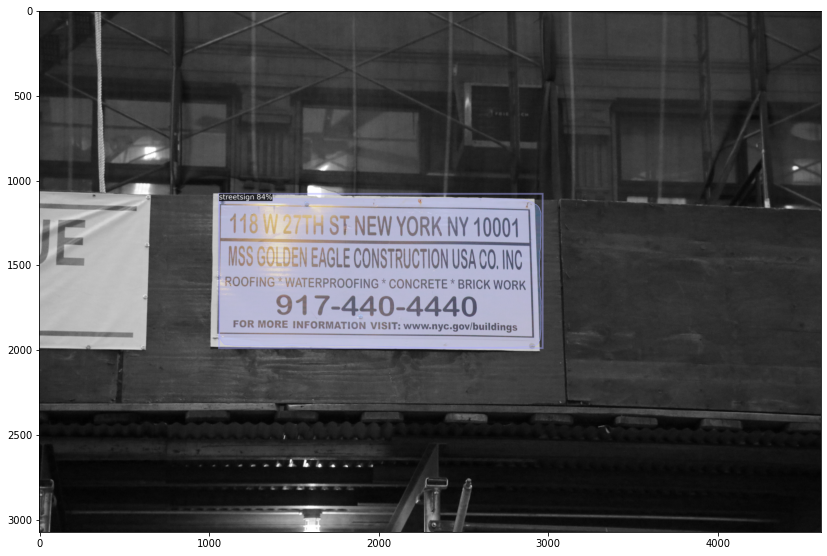

In [28]:
for d in random.sample(test_dataset_dicts, 1):    
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW # removes the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [20]:
!git clone https://github.com/facebookresearch/detectron2
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml --video-input video.mp4 --confidence-threshold 0.6 --output video-output.mkv \
  --opts MODEL.WEIGHTS /content/output/model_final.pth
     


     

Cloning into 'detectron2'...
remote: Enumerating objects: 14718, done.
remote: Total 14718 (delta 0), reused 0 (delta 0), pack-reused 14718
Receiving objects: 100% (14718/14718), 5.98 MiB | 18.33 MiB/s, done.
Resolving deltas: 100% (10670/10670), done.
[12/30 18:35:49 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml', input=None, opts=['MODEL.WEIGHTS', '/content/output/model_final.pth'], output='video-output.mkv', video_input='video.mp4', webcam=False)
[12/30 18:35:50 fvcore.common.checkpoint]: [Checkpointer] Loading from /content/output/model_final.pth ...
WARNING [12/30 18:35:50 fvcore.common.checkpoint]: Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (3, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
WARNING [12/30 18:35:50 fvcore.common.checkpoint]: Skip loading parameter

100%|██████████| 1283/1283 [07:02<00:00,  3.03it/s]


<Figure size 432x288 with 0 Axes>

In [21]:
# Download the results
from google.colab import files
files.download('video-output.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>